In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Find out the names of the columns for future reference
for c in Measurement.__table__.columns:
    print(c)

measurement.id
measurement.station
measurement.date
measurement.prcp
measurement.tobs


In [12]:
#take a look at the data in the rows
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
# Find the total number of rows in the table
session.query(func.count(Measurement.date)).all()

[(19550)]

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(last_date)

2017-08-23


In [15]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.date <= last_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
# print(precip_data)

In [17]:
# Create a dataframe from the query results and set the index to the date column
precip_data_df = pd.DataFrame(precip_data)
precip_data_df.set_index('date', inplace=True)
precip_data_df.head()

prcp
date            
2016-08-23  0.00
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00

Text(0.5, 1.0, 'Precipitation Over the Last 12 Months')

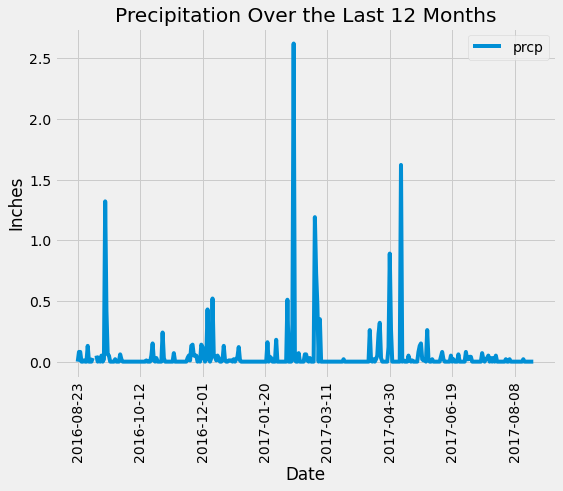

In [18]:
precip_data_df.plot(rot=90, figsize=(8, 6))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Over the Last 12 Months")

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()

prcp
count  364.000000
mean     0.048709
std      0.204930
min      0.000000
25%      0.000000
50%      0.000000
75%      0.020000
max      2.620000

In [20]:
# Find out the names of the columns
for c in Station.__table__.columns:
    print(c)

station.id
station.station
station.name
station.latitude
station.longitude
station.elevation


In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_data = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(station_data)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_temp_data = session.query(func.min(Measurement.tobs),\
                                  func.max(Measurement.tobs),\
                                  func.avg(Measurement.tobs)).\
                    filter(Measurement.station == 'USC00519281').all()

print(station_temp_data)

[(54.0, 85.0, 71.66378066378067)]


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp_data = session.query(Measurement.tobs, Measurement.date).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= query_date).\
    filter(Measurement.date <= last_date).\
    order_by(Measurement.date).all()
    
# print(highest_temp_data)

In [25]:
highest_temp_df = pd.DataFrame(highest_temp_data)
highest_temp_df.set_index('date', inplace=True)
highest_temp_df.head()

tobs
date            
2016-08-23  77.0
2016-08-24  77.0
2016-08-25  80.0
2016-08-26  80.0
2016-08-27  75.0

In [26]:
highest_temp_df.plot.hist(bins=12)
plt.xlabel("Temperature Interval")
plt.title("Frequency of Temperature for station 'USC00519281'")

Text(0.5, 1.0, "Frequency of Temperature for station 'USC00519281'")

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
